In [5]:
import os
import librosa   #thư viện xủ lý tín hiệu âm thanh
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #để đọc file wav 
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
train_audio_path = 'D:/DIGIREG/DATA/'
labels=os.listdir(train_audio_path)

Using TensorFlow backend.


In [3]:
from numpy import save
from numpy import asarray

WORD = 6000
WORD_HALF = int(WORD/2)
CHUNK = 10000 
all_wave = []
all_label = []
all_feature = []
for label in labels:
    print("Label:",label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
#         samples = librosa.resample(samples, sample_rate, 16000)
        
        leng = len(samples)
        chunk_count = int(leng/CHUNK)
        word_count = 0
        for i in range(0,chunk_count):
            data = samples[i*CHUNK:(i+2)*CHUNK]
            mean = np.mean(data)
            energy = abs(data)
            value = 0
            max_val = 0
            max_idn = 0
            for idn in range(0,len(energy)):
                value += (energy[idn]-value)/1000
                if (idn>WORD_HALF) & (idn<(len(data)-WORD_HALF )):
                    if max_val<value:
                        max_val = value
                        max_idn = idn
            if max_val>(mean*4):
                word_count = word_count+1
                data = data[max_idn-WORD_HALF:max_idn+WORD_HALF]
#                 feature_vector = librosa.feature.melspectrogram(y=data, sr=16000)[:40]
#                 feature_vector = librosa.feature.chroma_stft(y=data, sr=16000)
                all_wave.append(data)
#                 all_feature.append(feature_vector)
                all_label.append(label)
#         print(chunk_count," ",word_count)
save('all_wave', all_wave)
#save('all_feature', all_feature)
save('all_label', all_label)

Label: 0
Label: 1
Label: 2
Label: 3
Label: 4
Label: 5
Label: 6
Label: 7
Label: 8
Label: 9
Label: noise


4594
2.2413196092287633


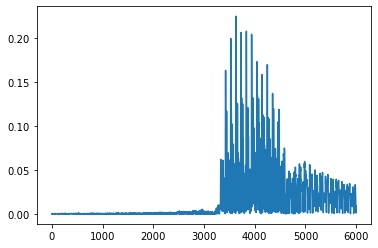

In [5]:
#test code
testId = 160
energy = abs(all_wave[testId])
mean =np.mean(energy)
value = 0
max_val = 0
max_idn = 0
for idn in range(0,len(energy)):
    value += (energy[idn]-value)/1000
    if max_val<value:
        max_val = value
        max_idn = idn
plt.plot(energy)
print(max_idn)
print(max_val/mean)
# mean = np.mean(energy)*2
# cfar = [1 if e > mean else 0 for e in energy]
# plt.plot(cfar)

In [6]:
ipd.Audio(all_wave[testId], rate=16000)

In [2]:
import matplotlib.pyplot as plt
import librosa.display

from numpy import load
from numpy import save
from numpy import asarray

all_wave = load('all_wave.npy')
# 
all_label = load('all_label.npy')
all_feature=[]
for word in all_wave:
#     feature_vector_1 = librosa.feature.chroma_stft(y=word, sr=16000)
#     feature_vector_2 = librosa.feature.melspectrogram(y=word, sr=16000)[:40]
#     feature_vector = np.concatenate((feature_vector_1*10,feature_vector_2))
#     all_feature.append(feature_vector)
    all_feature.append(word)


c:\python 3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python 3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [20]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'noise']

In [1]:

testId = 1200
print(all_label[testId])
feature_vector = all_feature[testId]

# plt.figure(figsize=(20, 4))
# librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('melspectrogram')
# plt.tight_layout()
# plt.show()
librosa.display.specshow(feature_vector, x_axis='time') 
plt.colorbar() 
plt.title('MFCC') 
plt.tight_layout()
ipd.Audio(all_wave[testId], rate=16000)

NameError: name 'all_label' is not defined

In [8]:
np.shape(all_feature)

(4965, 6000)

In [12]:
#data preprocessing
labels=os.listdir(train_audio_path)
from sklearn.preprocessing import LabelEncoder
all_feature = np.array(all_feature)
feature_vector = all_feature[0]
print(all_feature.shape)
feature_size = feature_vector.shape

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
# all_feature = np.array(all_feature).reshape(-1,feature_size[0],feature_size[1],1)
all_feature = np.array(all_feature).reshape(-1,feature_size[0],1)
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_feature),np.array(y),stratify=y,test_size = 0.3,random_state=555,shuffle=True)

(4965, 6000, 1, 1)


In [14]:
feature_size

(6000, 1, 1)

In [18]:
#thiết kế mô hình deep learning
from keras.models import Model, Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import Adam,RMSprop,SGD
model1 = Sequential()
model1.add(Conv1D(8, kernel_size=13, strides=1, padding='valid',
                  input_shape=(feature_size[0],1)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling1D(pool_size=3))
model1.add(Dropout(0.3))

model1.add(Conv1D(16, kernel_size=11, strides=1, padding='valid'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling1D(pool_size=3))
model1.add(Dropout(0.3))

model1.add(Conv1D(32, kernel_size=9, strides=1, padding='valid'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling1D(pool_size=3))
model1.add(Dropout(0.3))

model1.add(Conv1D(64, kernel_size=7, strides=1, padding='valid'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling1D(pool_size=3))
model1.add(Dropout(0.3))

# model1.add(Conv1D(128, kernel_size=5, strides=1, padding='valid'))
# model1.add(LeakyReLU(alpha=0.1))
# model1.add(MaxPooling1D(pool_size=3))
# model1.add(Dropout(0.3))
           
model1.add(Flatten())

model1.add(Dense(64))
model1.add(Dropout(0.1))

model1.add(Dense(11))
# model1.add(Dropout(0.1))

model1.add(Activation('softmax'))
# adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

# learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.005
    elif epoch < 40:
        return 0.002
    elif epoch < 80:
        return 0.001
    else:
        return 0.0005
callbacks = [LearningRateScheduler(schedule=lr_schedule, verbose=1),
#              TensorBoard("./", histogram_freq=0, write_graph=True, write_images=False)
#              ,
#              ModelCheckpoint(
#                  os.path.join("./", "cp_{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5"),
#                  monitor='val_loss', verbose=1, save_best_only=True)
            ]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 5988, 8)           112       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5988, 8)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1996, 8)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1996, 8)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1986, 16)          1424      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1986, 16)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 662, 16)          

In [27]:
#thiết kế mô hình deep learning
from keras.models import Model, Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import Adam,RMSprop,SGD
model1 = Sequential()


model1.add(Conv2D(16, kernel_size=(5, 5), strides= (1, 1), padding='same',data_format='channels_last',
                  input_shape=(feature_size[0], feature_size[1],1)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# model1.add(Conv2D(32, kernel_size=(5, 5), strides= (1, 1), padding='same'))
# model1.add(LeakyReLU(alpha=0.1))
model1.add(Conv2D(32, kernel_size=(5, 5), strides= (1, 1), padding='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# model1.add(Conv2D(64, kernel_size=(3, 3), strides= (1, 1), padding='same'))
# model1.add(LeakyReLU(alpha=0.1))
# model1.add(Conv2D(32, kernel_size=(3, 3), strides= (1, 1), padding='same'))
# model1.add(LeakyReLU(alpha=0.1))
# model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dropout(0.3))

model1.add(Dense(32))
model1.add(Dropout(0.1))

# model1.add(Dense(32))
# model1.add(Dropout(0.1))

# model1.add(Dense(32))
# model1.add(Dropout(0.1))
model1.add(Dense(11))
model1.add(Activation('softmax'))
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = SGD(lr=0.0005, momentum=0.9)
model1.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model1.summary()
# learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.005
    elif epoch < 40:
        return 0.002
    elif epoch < 80:
        return 0.001
    else:
        return 0.0005
callbacks = [LearningRateScheduler(schedule=lr_schedule, verbose=1),
#              TensorBoard("./", histogram_freq=0, write_graph=True, write_images=False)
#              ,
#              ModelCheckpoint(
#                  os.path.join("./", "cp_{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5"),
#                  monitor='val_loss', verbose=1, save_best_only=True)
            ]


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 52, 12, 16)        416       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 52, 12, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 26, 6, 16)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 6, 32)         12832     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 26, 6, 32)         0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 3, 32)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1248)            

In [19]:
#luyện mô hình 
classifier = model1.fit(x_tr,
                    y_tr,validation_data=( x_val, y_val),
                    callbacks=callbacks,
                    validation_steps = 5,
                    steps_per_epoch = 20,
                    epochs=25,
                    batch_size=None)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3475 samples, validate on 1490 samples
Epoch 1/25






Epoch 00001: LearningRateScheduler setting learning rate to 0.005.


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[3475,1,5988,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d_9/convolution-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_2/acc/Mean/_219]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[3475,1,5988,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1d_9/convolution-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [54]:
#luyện mô hình 
classifier = model1.fit(x_tr,
                    y_tr,validation_data=( x_val, y_val),
                    callbacks=callbacks,
                    validation_steps = 5,
                    steps_per_epoch = 20,
                    epochs=150,
                    batch_size=None)

Train on 4468 samples, validate on 497 samples
Epoch 1/5
4468/4468 [==============================] - 1s 149us/step - loss: 0.3042 - acc: 0.9223 - val_loss: 0.3905 - val_acc: 0.9276
Epoch 2/5
4468/4468 [==============================] - 0s 35us/step - loss: 0.3022 - acc: 0.9197 - val_loss: 0.3889 - val_acc: 0.9276
Epoch 3/5
4468/4468 [==============================] - 0s 35us/step - loss: 0.2959 - acc: 0.9257 - val_loss: 0.3859 - val_acc: 0.9276
Epoch 4/5
4468/4468 [==============================] - 0s 34us/step - loss: 0.2975 - acc: 0.9259 - val_loss: 0.3935 - val_acc: 0.9296
Epoch 5/5
4468/4468 [==============================] - 0s 35us/step - loss: 0.2910 - acc: 0.9228 - val_loss: 0.4045 - val_acc: 0.9296


In [29]:
#kiểm tra mô hình sau khi luyện
for idn in range(0,800):
    output = model1.predict(all_feature)[idn]
    indexMax = np.argmax(output, axis=0) 
    if  int(all_label[idn]) != indexMax:
        print ( "id:",idn," prediction:",indexMax," value:", output[indexMax])
        print ("truth:",all_label[idn])
        
#     ipd.Audio(all_wave[testId], rate=16000)

id: 81  prediction: 5  value: 0.2565638
truth: 0
id: 96  prediction: 7  value: 0.8533482
truth: 0
id: 159  prediction: 2  value: 0.7047071
truth: 0
id: 189  prediction: 2  value: 0.990704
truth: 1
id: 215  prediction: 7  value: 0.46284044
truth: 1
id: 243  prediction: 10  value: 0.9880684
truth: 1
id: 269  prediction: 10  value: 0.9993699
truth: 1
id: 271  prediction: 10  value: 0.9185716
truth: 1
id: 357  prediction: 5  value: 0.98147446
truth: 1
id: 509  prediction: 3  value: 0.5198695
truth: 2
id: 566  prediction: 10  value: 0.9804715
truth: 2
id: 591  prediction: 10  value: 0.9901833
truth: 2
id: 592  prediction: 10  value: 0.99996126
truth: 2
id: 593  prediction: 10  value: 1.0
truth: 2
id: 594  prediction: 10  value: 1.0
truth: 2
id: 761  prediction: 10  value: 1.0
truth: 3
id: 776  prediction: 10  value: 1.0
truth: 3


In [38]:
ipd.Audio(all_wave[80], rate=16000)

In [ ]:
all_label[idn]

In [ ]:
all_label[40]

In [16]:
# lưu kiến trúc của model đã luyện vào file json
model_json = model1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# lưu các trọng số của model
model1.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [93]:
print("* init")
import os
import IPython.display as ipd
# from scipy.io import wavfile #để đọc file wav 
# import warnings
import tensorflow as tf
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import socket
import pyaudio
import wave
import struct
CHUNK = 16000 # read each 1000 miliseconds
FORMAT = pyaudio.paFloat32
CHANNELS = 1
RATE = 16000
RECORD_SECONDS = 20
WORD = 6000
WORD_HALF = int(WORD/2)
WORD_QUAD = int(WORD/2)
# circular_buf_size = 50
p = pyaudio.PyAudio()
model =model1
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)
frames = []
features = []
waves = []
words = []
circular_index = 0
os.system( 'cls' )
print("* recording")
inputDataNew = np.ndarray(shape=(CHUNK), dtype=float)
inputDataOld = np.ndarray(shape=(WORD_QUAD), dtype=float)
last_word_time = 0
i=0
while 1:
    data = stream.read(CHUNK) 
    #convert to float array
    for j in range(0, int(len(data)/4)):
        value = struct.unpack('f', data[j*4:j*4+4])
        inputDataNew[j] = value[0]
    #megre end of old and new
    inputData = np.concatenate((inputDataOld,inputDataNew))
    inputDataOld = inputDataNew[CHUNK-WORD_QUAD:].copy()
    i=i+1
    if i<2:
        continue
    else:
        mean = np.mean(inputData)
        energy = abs(inputData)
        value = 0
        max_val = 0
        max_idn = 0
        for idn in range(0,len(energy)):
            value += (energy[idn]-value)/300
            if (idn>WORD_HALF) & (idn<(len(inputData)-WORD_HALF )):
                if max_val<value:
                    max_val = value
                    max_idn = idn
        if max_val>(mean*6):
            global_time = i*CHUNK+max_idn-WORD_QUAD
            if (global_time-last_word_time)< WORD:
                continue
            last_word_time = global_time
            data = inputData[max_idn-WORD_HALF:max_idn+WORD_HALF]
            feature_vector_1 = librosa.feature.chroma_stft(y=data, sr=16000)
            feature_vector_2 = librosa.feature.melspectrogram(y=data, sr=16000)[:40]
            feature_vector = np.concatenate((feature_vector_1*10,feature_vector_2))
            modelInput = np.array(feature_vector).reshape(1,feature_vector.shape[0],feature_vector.shape[1],1)
            output = model.predict(modelInput)
            indexMax = np.argmax(output[0], axis=0) 
            confident = output[0][indexMax]
            if (confident>0.8):
#             os.system( 'cls' )
                print ("ID:",len(waves)," prediction:",indexMax,"confident:",output[0][indexMax]," time:",global_time/RATE)
                waves.append(inputData)
                words.append(data)
                features.append(feature_vector)
                byte_message = (indexMax)
                opened_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
                opened_socket.sendto(byte_message, ("127.0.0.1", 5005))
#             plt.figure(figsize=(10, 4))
#             librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
#             plt.colorbar()
#             plt.title('Chromagram')
#             plt.tight_layout()
#             plt.show()
print("* done recording")    

* init
* recording
ID: 0  prediction: 10 confident: 0.9128904  time: 2.072875
ID: 1  prediction: 10 confident: 0.96170497  time: 3.5160625
ID: 2  prediction: 7 confident: 0.95377135  time: 4.68825
ID: 3  prediction: 3 confident: 0.93718827  time: 6.46125
ID: 4  prediction: 10 confident: 0.90602446  time: 7.19025
ID: 5  prediction: 4 confident: 0.99794513  time: 9.5256875
ID: 6  prediction: 10 confident: 0.8033655  time: 10.567375
ID: 7  prediction: 10 confident: 0.87282985  time: 14.7904375
ID: 8  prediction: 7 confident: 0.96272224  time: 15.1679375
ID: 9  prediction: 4 confident: 0.9824702  time: 18.2704375
ID: 10  prediction: 10 confident: 0.83502096  time: 19.0089375
ID: 11  prediction: 10 confident: 0.92343414  time: 21.42
ID: 12  prediction: 3 confident: 0.9954478  time: 22.6264375
ID: 13  prediction: 10 confident: 0.9305228  time: 23.475625
ID: 14  prediction: 10 confident: 0.8031464  time: 24.490125
ID: 15  prediction: 8 confident: 0.83166265  time: 25.5585625
ID: 16  predictio

KeyboardInterrupt: 

In [21]:
ipd.Audio(words[5], rate=16000)